# Segmentation networks

We will use LinkNet, UNet, FCN32 and FCN8 (realized as TFModel) to segmenation of $64 \times 64$ images with MNIST $28 \times 28$ at random place (uniformly sampled) with noise generated on the base of MNIST fragments. Each fragment is randomly cutted from random image from the same batch and is rotated by an angle $ \sim U(0,360^{\circ})$. Coordinates of top-left corner are sampled from uniform $U(0, 64-s)$ or normal $N\left(\frac{64-s}{2}, \left(\frac{64-s}{4}\right)^2\right)$ distribution where $s$ is equal to width (height) of rotated image.

In [1]:
import sys
from time import time
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../..')

from dataset import Pipeline, DatasetIndex, Dataset, B, V

from dataset.opensets import MNIST
from dataset.models.tf import UNet, LinkNet, FCN32, FCN8
from noised_mnist import NoisedMnist                                          # Batch subclass with loading and noise actions
from plot_functions import plot_noised_image, plot_examples_highlighted       # plot functions to demonstrate result 

Fix constants to generate noised images and train LinkNet:

In [2]:
IMAGE_SIZE = 64     # image size
MNIST_SIZE = 65000  # MNIST database size
BATCH_SIZE = 32     # batch size for NN training
MAX_ITER = 100      # number of iterations for NN training

Define noise parameters:

In [3]:
level = 1           # the highest level of noise; [0, 1]
n_fragments = 80    # number of noise fragments per image  
size = 4            # size of noise fragment; 1, ..., 27
distr = 'uniform'   # distribution of fragments of image; 'uniform' or 'normal'

Create DatasetIndex and Dataset to use pipelines:

In [4]:
mnistset = MNIST(batch_class=NoisedMnist)

Extracting ExtractingExtractingExtractingC:\Users\kozhevin\AppData\Local\Temp\train-labels-idx1-ubyte.gz  
 C:\Users\kozhevin\AppData\Local\Temp\t10k-labels-idx1-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\t10k-images-idx3-ubyte.gz
C:\Users\kozhevin\AppData\Local\Temp\train-images-idx3-ubyte.gz



Сreate Pipeline template for image loading and transformation. The first parameter of create_noise is the type of noise: 'mnist_noise' - MNIST-based noise, 'random_noise' - uniform random noise.

In [5]:
load_template = (Pipeline()
                 .random_location(IMAGE_SIZE)      # put MNIST at random location
                 .make_masks()                     # create mask for MNIST image location
                 .create_noise('mnist_noise', level, n_fragments, size, distr))

Create config for placeholders of the model. Key in dict is name of the created placeholder.
* '<b>shape</b>' - shape of the input of model
* '<b>type</b>' - tf.dtype of input
* '<b>data_format</b>' - one of channels_last (default) or channels_first
* '<b>name</b>' - name of the placeholder after reshaping 

In [6]:
placeholders_config = {
                       'images': {'shape': (IMAGE_SIZE, IMAGE_SIZE, 1),
                                  'type': 'float32',
                                  'name': 'reshaped_images'},
                
                       'masks': {'shape': (IMAGE_SIZE, IMAGE_SIZE),
                                 'type': 'int32',
                                 'transform': 'ohe',
                                 'classes': 2,
                                 'name': 'targets'}
                       }

Create model_config.
* '<b>inputs</b>' - dict of placeholders configs
* '<b>input_block/inputs</b>' - name of tensor which is an input of input block
* '<b>batch_norm</b>' - enable batch normalization
* '<b>n_blocks</b>' - number of encoding/decoding blocks (4 by default)
* '<b>n_filters</b>' - number of filters after the first convolution (64 by default)
* '<b>output</b>' - dict of operations to add into graph
* '<b>loss</b>' - loss function
* '<b>optimizer</b>' - loss function

In [7]:
model_config = {'inputs': placeholders_config,
                'input_block/inputs': 'images',
                'batch_norm': {'momentum': 0.1},
                'output': dict(ops=['proba']),
                'loss': 'softmax_cross_entropy',
                'optimizer': 'Adam'}

Create feed dicts. The key is name of the tensor in tf graph, value is batch component.

In [8]:
train_feed_dict = {'images': B('images'),
                   'masks': B('masks')}        

test_feed_dict = {'images': B('images'),
                  'masks': B('masks')}

In [9]:
def demonstrate_model(model):
    print('Create pipelines...')

    ppl_train = ((load_template << mnistset.train)                         # load data from file
            .add_noise()                                                   # add MNIST-noise to images
            .init_model('static', model, 'NN', config=model_config)
            .train_model('NN',                                             # model name
                         feed_dict=train_feed_dict))

    print('Start training...')
    start = time()
    for i in range(MAX_ITER):
        ppl_train.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)
    stop = time()
    linknet_time = (stop - start) / 60
    print("Train time: {:05.3f} min".format((stop-start)/60))

    ppl_test = ((load_template << mnistset.test)
             .add_noise()                   
             .import_model('NN', ppl_train)
             .init_variable('predictions', init_on_each_run=list)
             .predict_model('NN',                                      
                           fetches=model.__name__+'/predicted_proba',
                           feed_dict=test_feed_dict,
                           save_to=V('predictions'),
                           mode='a'))

    batch = ppl_test.next_batch(100, n_epochs=None)
    images = batch.data.images
    masks = batch.data.masks
    noise = batch.data.noise
    predictions = ppl_test.get_variable('predictions')[-1]

    intersection = np.sum(np.logical_and((predictions[:,:,:,1] > 0.5), masks[:,:,:]))
    union = np.sum(np.logical_or((predictions[:,:,:,1] > 0.5), masks[:,:,:]))
    iou = intersection / union
    print('Test IoU: {0:.3f}'.format(iou))
    
    plot_examples_highlighted(ppl_test, 5, model.__name__)

Create pipelines...
Start training...
Train time: 1.583 min
Test IoU: 0.879


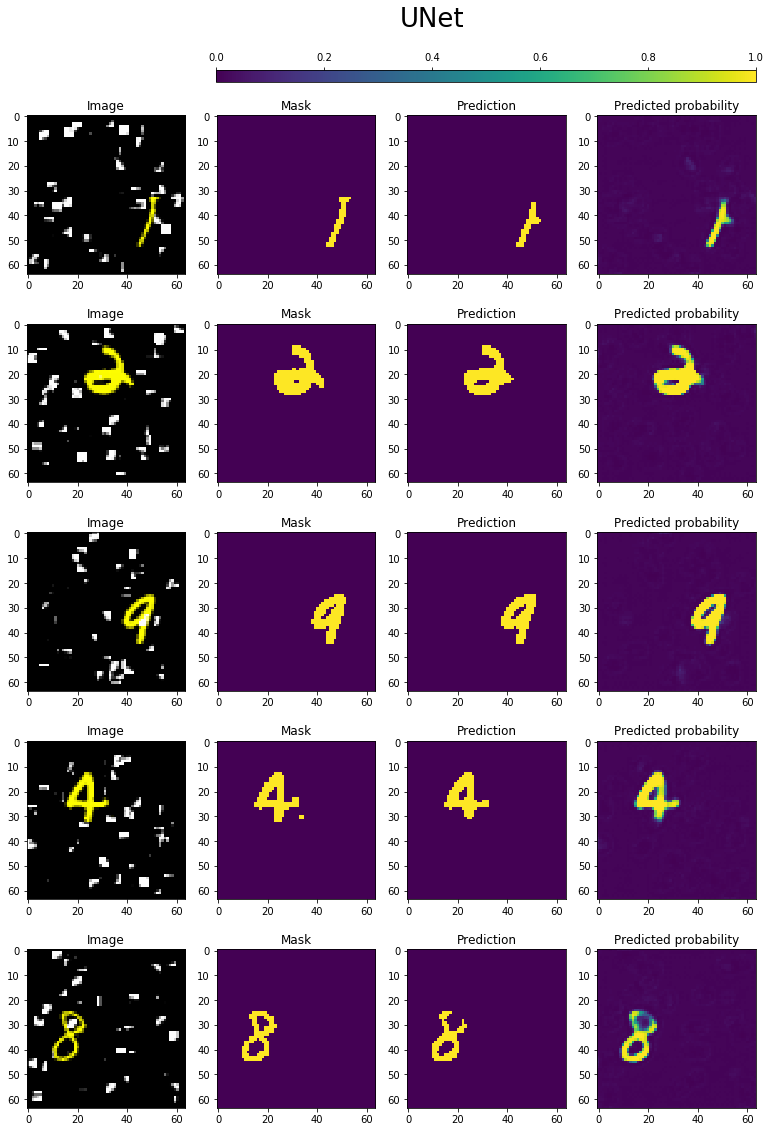

In [10]:
demonstrate_model(UNet)

Create pipelines...
Start training...
Train time: 0.787 min
Test IoU: 0.608


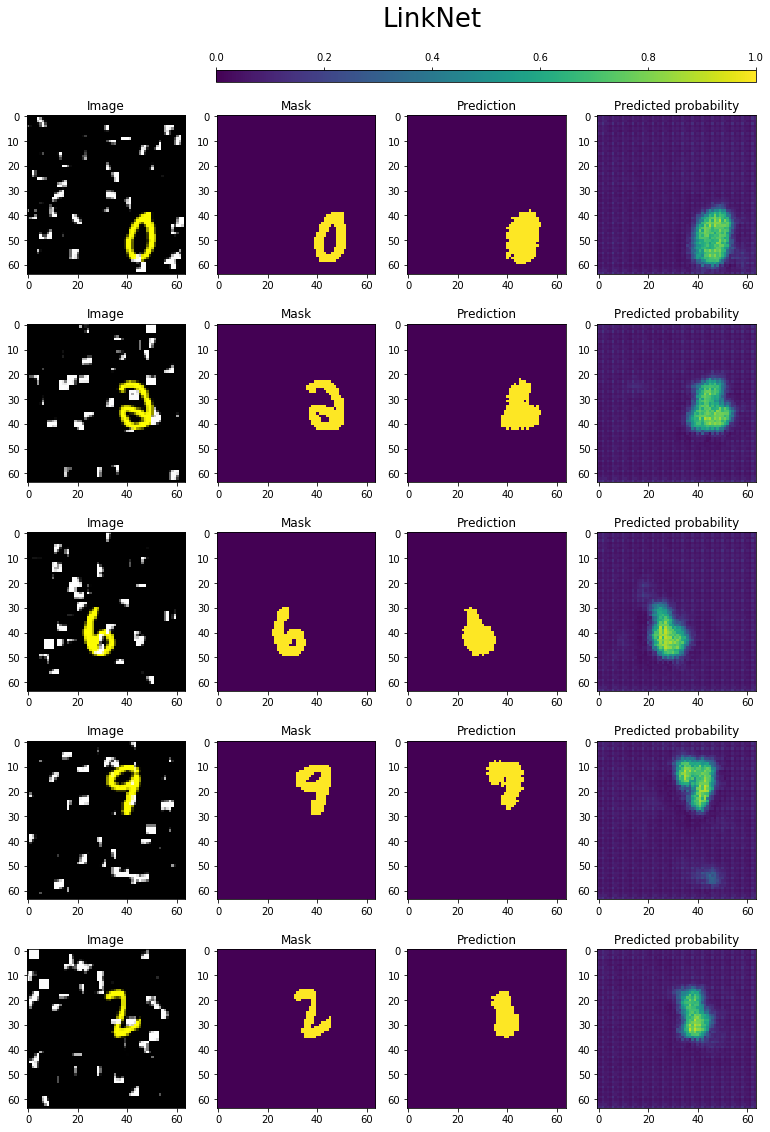

In [11]:
demonstrate_model(LinkNet)

Create pipelines...
Start training...
Train time: 0.968 min
Test IoU: 0.000


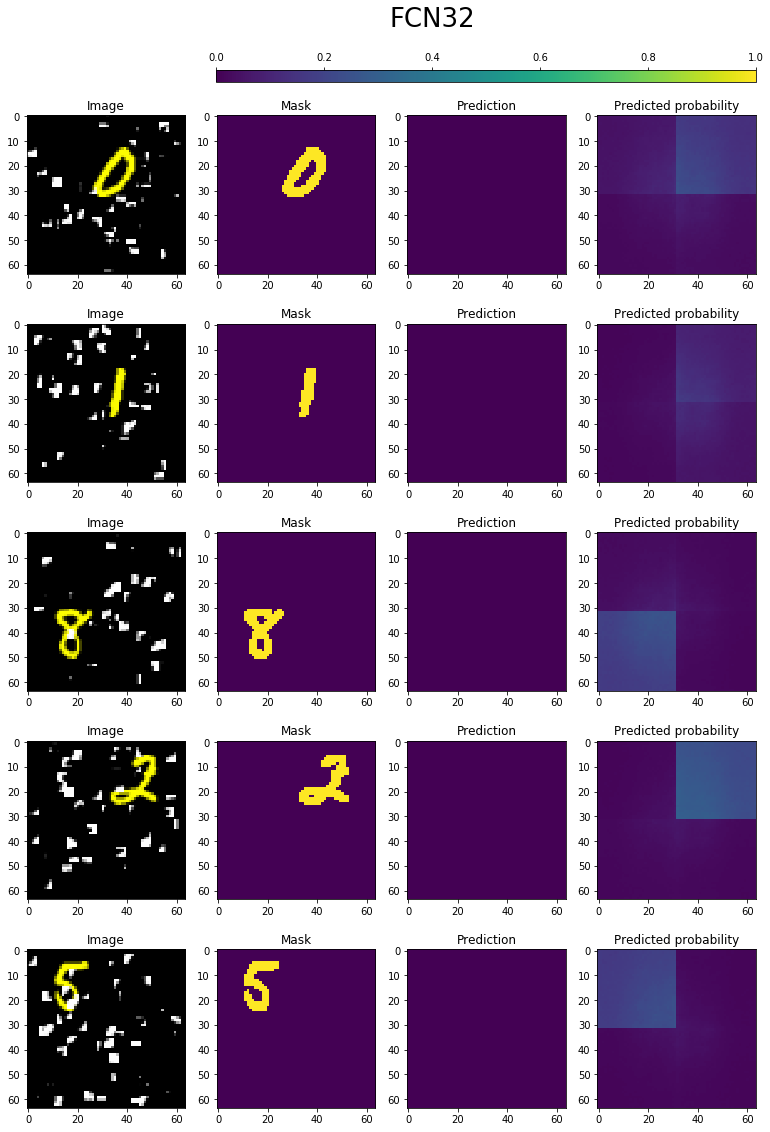

In [12]:
demonstrate_model(FCN32)

Create pipelines...
Start training...
Train time: 0.976 min
Test IoU: 0.341


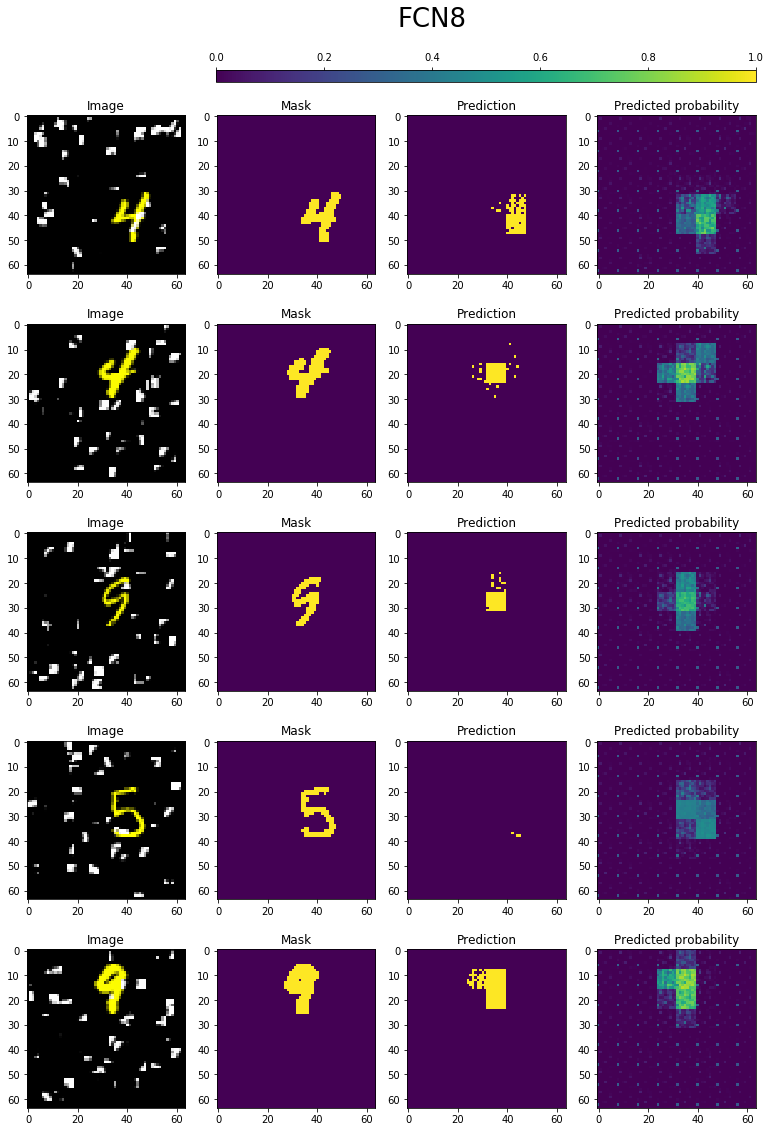

In [13]:
demonstrate_model(FCN8)